In [1]:
import os
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras

import pandas as pd

2023-11-23 11:10:09.271810: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 11:10:09.302472: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 11:10:09.812687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import keras_cv

Using TensorFlow backend


In [3]:
from keras_cv import bounding_box
from keras_cv import visualization

In [4]:
    SPLIT_RATIO = 0.2
    BATCH_SIZE = 4
    LEARNING_RATE = 0.001
    EPOCH = 5
    GLOBAL_CLIPNORM = 10.0

In [5]:
!ls

 BinaryClassifier   frcnn	    'yolov5 training commands'
 coco128	    mrcnn	     yolov8
 export		    Untitled.ipynb   YOLOv8_Training.ipynb
 export.zip	    yolov5s.pt


In [6]:
class_ids = [
    "apple",
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [7]:
class_ids

['apple']

In [8]:
class_mapping

{0: 'apple'}

In [9]:
# Path to images and annotations
path_images = "./export/export/train/images"
path_annot = "./export/export/train/labels"

In [10]:
# Get all TXT file paths in path_annot and sort them
txt_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".txt")
    ]
)


In [11]:
# Get all PNG image file paths in path_images and sort them
image_paths = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".png")
    ]
)

In [14]:
def parse_annotation(txt_file):
    df = pd.read_csv(txt_file, sep=' ', names=['id', 'xmin', 'xmax', 'ymin', 'ymax'])

    boxes = [list(df[['xmin', 'xmax', 'ymin', 'ymax']].iloc[i]) for i in range(len(df))]
    boxes = [[640 * boxes[i][0],  640 * boxes[i][1] + 5,  640 * boxes[i][2],  640 * boxes[i][3]]  for i in range(len(df))]
    classes = list(df['id'])
    
    return boxes, classes

In [15]:
txt_files[0]

'./export/export/train/labels/data-1.txt'

In [16]:
parse_annotation(txt_files[0])

([[142.14458562091457, 147.14458562091457, 36.864, 16.852114285714304],
  [224.06458562091456,
   229.06458562091456,
   36.40888888888883,
   20.831085714285695],
  [0.440386928104576,
   5.4403869281045765,
   25.164967320261376,
   16.048059159663808],
  [144.51116339869313,
   149.51116339869313,
   30.09623006535936,
   15.880088739495807],
  [226.58978300653632,
   231.58978300653632,
   37.265568627450946,
   18.526311260504126],
  [419.9223215686278, 424.9223215686278, 39.25734901960768, 20.90543327731085],
  [457.2307241830067,
   462.2307241830067,
   27.842091503267902,
   15.607481008403328],
  [571.4181019607847, 576.4181019607847, 34.94717908496717, 21.33224336134445],
  [578.1483921568627,
   583.1483921568627,
   37.886661437908415,
   15.789219495798273],
  [615.7084444444442,
   620.7084444444442,
   24.169077124182913,
   22.172095462184767]],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
bbox = []
classes = []
for txt_file in tqdm(txt_files):
    boxes, class_ids = parse_annotation(txt_file)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/804 [00:00<?, ?it/s]

In [18]:
bbox = tf.ragged.constant(bbox)

2023-11-23 11:11:39.562298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 11:11:39.565973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 11:11:39.566070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [19]:
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [20]:
# Determine the number of validation samples
num_val = int(len(txt_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [21]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [22]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

In [23]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [27]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

In [28]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [29]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [30]:

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [31]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/3


2023-11-23 11:11:56.708914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-23 11:12:03.197617: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-23 11:12:03.435238: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef6d81009c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 11:12:03.435258: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-11-23 11:12:03.438964: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-23 11:12:03.510971: I ./ten

161/161 [==============================] - ETA: 0s - loss: 1402.1812 - box_loss: 0.4757 - class_loss: 1401.7052

2023-11-23 11:12:36.809997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


161/161 [==============================] - 53s 162ms/step - loss: 1402.1812 - box_loss: 0.4757 - class_loss: 1401.7052 - val_loss: 5.3253 - val_box_loss: 0.5881 - val_class_loss: 4.7372
Epoch 2/3
161/161 [==============================] - 25s 154ms/step - loss: 2.7156 - box_loss: 0.7581 - class_loss: 1.9575 - val_loss: 9159.7920 - val_box_loss: 0.1159 - val_class_loss: 9159.6768
Epoch 3/3
161/161 [==============================] - 26s 156ms/step - loss: 2.5998 - box_loss: 1.1443 - class_loss: 1.4555 - val_loss: 711.1663 - val_box_loss: 1.3996 - val_class_loss: 709.7667


1/1 [==============================] - 2s 2s/step


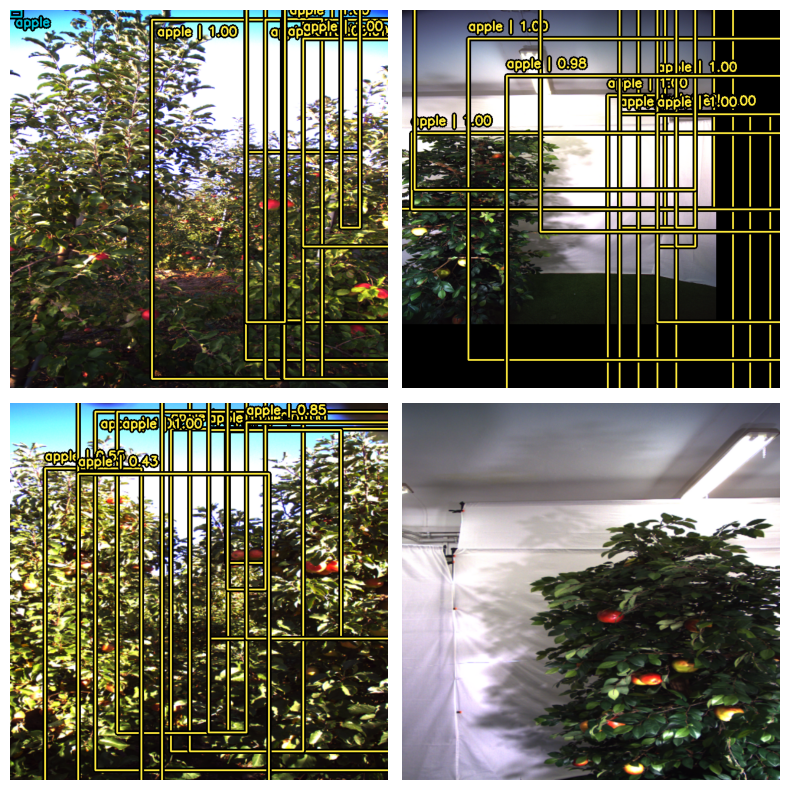

In [32]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")